(C) Julius Hense & Mina Jamshidi @ TU Berlin, 2024

This notebook replicates the plots and results of patch flipping experiments.

# Section 1:  load the data

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import os
import json

import numpy as np
from scipy.stats import ttest_rel

import seaborn as sns
import matplotlib.pyplot as plt


from visualization.evaluation import plot_perturbation_curve, plot_ave_prob_boxplots
from visualization.utils import compute_auc

In [ ]:

# from copy import deepcopy
# import pandas as pd

# from sklearn import metrics
# from matplotlib.cbook import boxplot_stats

# from visualization.utils import plot_line_mean_se
# from visualization.evaluation import (plot_boxplot_with_significance, 
#                                       plot_perturbation_curve, plot_ave_prob_boxplots)
# from visualization.evaluation import plot_perturbation_curve, plot_ave_prob_boxplots
# from visualization.evaluation import plot_boxplot_with_significance

# from scipy import stats
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
def load_json(load_dir, name):
    with open(os.path.join(load_dir, name), 'r') as f:
        loaded_data = json.load(f)
    return loaded_data

In [17]:
def get_data(results_dir, heatmap_types, test_dataset='test'):
    """
    results_dir: dictionary of the results directories with keys of the projects (nsclc, hpv_hnsc, camelyon, luad_tp53)
    heatmap_types: a list of heatmap types
    """
    probs = {}
    skip_ids_all = {}
    for proj_label, project in zip(project_label, projects):


        # results_dir_proj = os.path.join(results_dir_root, project)
        # folder_name = [dir_ for dir_ in os.listdir(results_dir_proj) if f'{model_name}_test_drop_flip_{flip_perc}_' in dir_][0]
        # results_dir = os.path.join(results_dir_proj, folder_name)


        probs[project] = {heatmap_type: load_json(results_dir[project], f'probs_{heatmap_type}_drop_test.json') 
                 for heatmap_type in heatmap_types}


        false_preds = load_json(results_dir[project], f'false_preds_drop_test.json')
        skipped = load_json(results_dir[project], f'skipped_drop_test.json')


        skip_ids = skipped + false_preds
        skip_ids_all[project] = skip_ids
  
    return probs, skip_ids_all

In [22]:
results_dir_root = 'path/to/patch_flipping' 
fig_save_dir = os.path.join(results_dir_root, 'figures')

projects = ['camelyon', 'nsclc', 'hnsc_hpv', 'luad_tp53']
project_label = ['Camelyon', 'NSCLC', 'HNSC HPV', 'LUAD TP53']  # the label to be used in the figures

heatmap_types = ['lrp', 'gi', 'occlusion_keep', 'attention', 'baseline']
heatmap_types_label = ['LRP', 'GxI', 'Single', 'Attn', 'Rand'] 

fontsize = 12

flip_steps = np.arange(0, 101, 1)


In [10]:

colors = ["#D81B60", "#1E88E5", "#FFC107", "#8AB187", "#E8613E", "#8BD4E7" ]

palette = sns.color_palette(colors)

In [18]:

results_dir_attnmil = {proj: os.path.join(results_dir_root, proj, 'attnmil') for proj in projects}

probs_attnmil_drop, skip_ids_attnmil = get_data(results_dir_attnmil, heatmap_types)





In [19]:
results_dir_transmil = {proj: os.path.join(results_dir_root, proj, 'transmil') for proj in projects}


probs_transmil_drop, skip_ids_transmil = get_data(results_dir_transmil, heatmap_types)


# AttnMIL DROP

/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:67: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.boxplot(data, notch=notch, palette=palette, showfliers=False)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:67: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.boxplot(data, notch=notch, palette=palette, showfliers=False)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:67: UserWarning: The palett

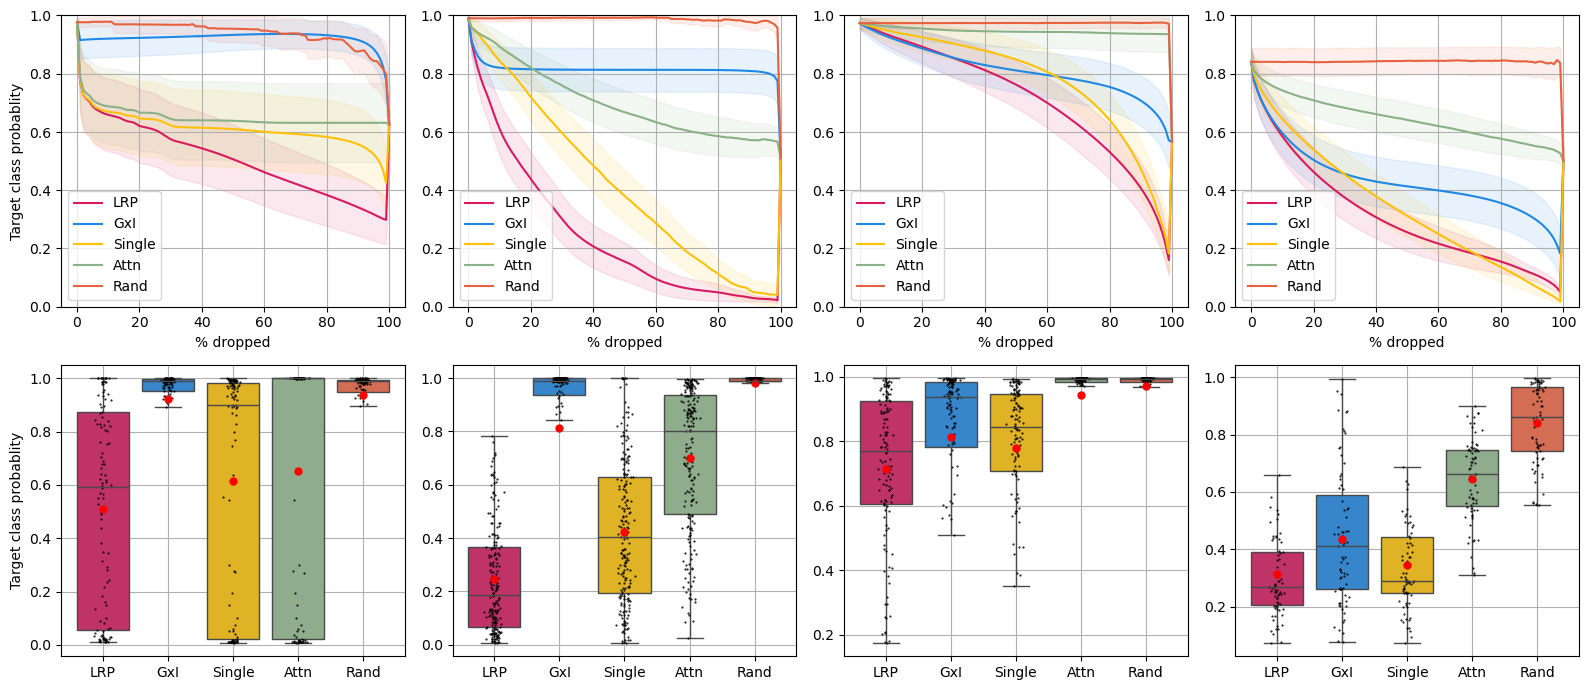

In [56]:
fig = plt.figure(figsize=(16, 7))
i = 0
for project, proj_label in zip(projects, project_label):
    i += 1
    plt.subplot(2, 4, i)
    if i == 1:
        ylabel = 'Target class probablity'
    else:
        ylabel = ''
    
    plot_perturbation_curve(probs_attnmil_drop[project],
                            flip_steps, skip_ids_attnmil[project], palette, '% dropped', ylabel, heatmap_types_label,
                            n_se=3, std=False)

    ax2 = plt.subplot(2, 4, 4 + i)
    
    plot_ave_prob_boxplots(probs_attnmil_drop[project], heatmap_types_label, palette, skip_ids_attnmil[project], 
                          ylabel, showfliers=False, verbose=False)


plt.tight_layout()
fig.savefig(os.path.join(fig_save_dir, f'attnmil_drop_colorblind.pdf')) 
fig.savefig(os.path.join(fig_save_dir, f'attnmil_drop_colorblind.svg')) 

## ttest results attnMIL

In [31]:
for project in projects:
    print(project)
    ave_prob = compute_auc(probs_attnmil_drop[project], skip_ids_attnmil[project])
    
    
    bonferroni_factor = 7
    ind1 = 0
    for ind2 in range(1, len(ave_prob)):
        tval, pval = ttest_rel(ave_prob[ind1], ave_prob[ind2])
        pval *= bonferroni_factor
        print(f'{ind1} - {ind2}: {pval}')
    
    print('*********')
    ind2 = len(ave_prob) - 1
    for ind1 in range(1, len(ave_prob) - 1):
        tval, pval = ttest_rel(ave_prob[ind1], ave_prob[ind2])
        pval *= bonferroni_factor
        print(f'{ind2} - {ind1}: {pval}')
            

camelyon
0 - 1: 4.834146188232876e-22
0 - 2: 6.634664631773723e-10
0 - 3: 1.2876292693892697e-09
0 - 4: 4.050830207110945e-24
*********
4 - 1: 0.9498865673006511
4 - 2: 3.8049553947699155e-13
4 - 3: 9.214547641184813e-10
nsclc
0 - 1: 4.689289110041355e-69
0 - 2: 3.469041053929836e-66
0 - 3: 1.840951881820761e-76
0 - 4: 2.9456277820288597e-119
*********
4 - 1: 1.150104479546793e-11
4 - 2: 1.918865330791636e-82
4 - 3: 2.974007004791908e-36
hnsc_hpv
0 - 1: 3.617637217562955e-15
0 - 2: 3.000154718284926e-10
0 - 3: 1.7935262418782395e-21
0 - 4: 4.9496819042239154e-26
*********
4 - 1: 5.345585889411749e-14
4 - 2: 4.409151035910422e-22
4 - 3: 0.25541928812750797
luad_tp53
0 - 1: 2.603886658195026e-11
0 - 2: 7.992167051488862e-14
0 - 3: 4.1969759325586926e-37
0 - 4: 1.1219014046464555e-45
*********
4 - 1: 3.2351799913721655e-34
4 - 2: 1.135343319920476e-43
4 - 3: 2.6961597159986885e-16


# TransMIL DROP

/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:67: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.boxplot(data, notch=notch, palette=palette, showfliers=False)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:67: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.boxplot(data, notch=notch, palette=palette, showfliers=False)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/Users/mina/Documents/Codes/My_codes/Digital_Pathology/xMIL/visualization/utils.py:67: UserWarning: The palett

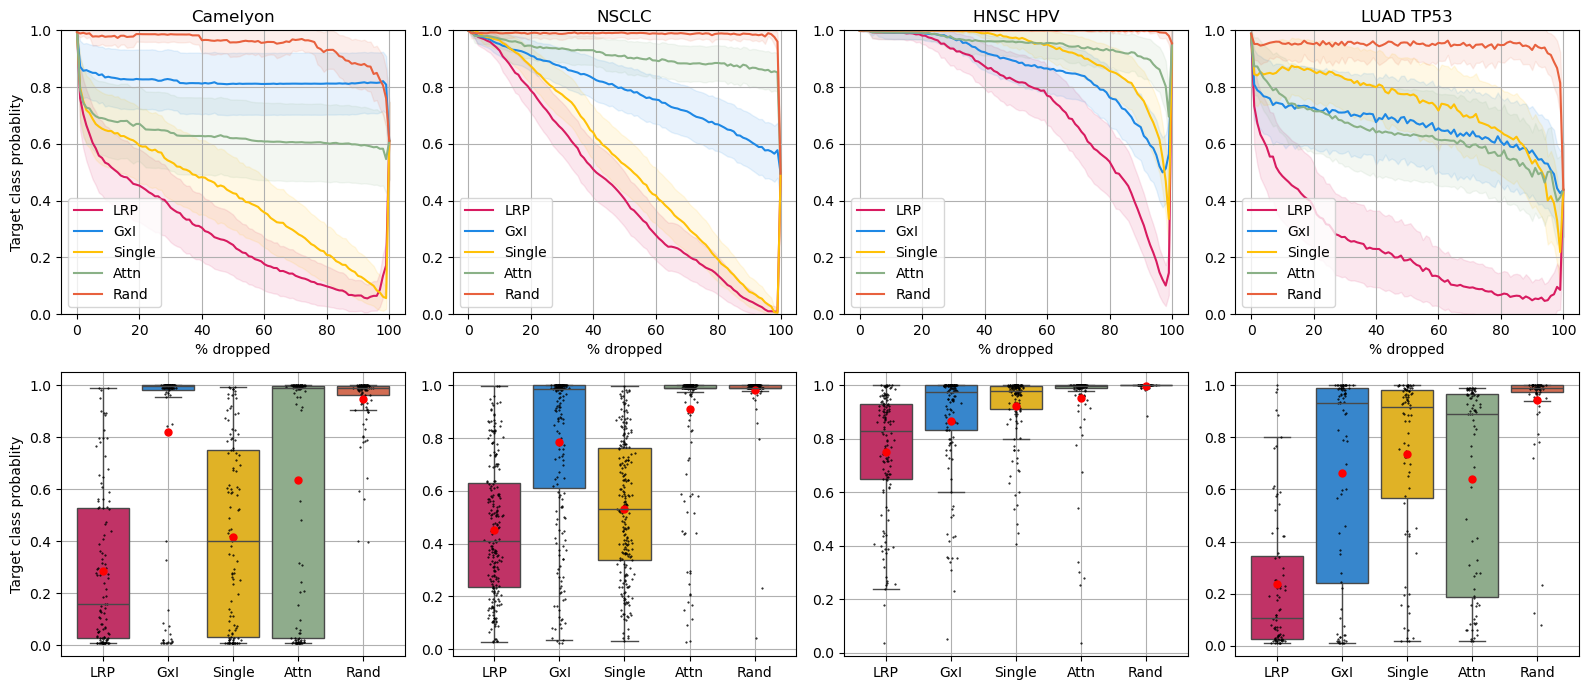

In [54]:
fig = plt.figure(figsize=(16, 7))
i = 0
for project, proj_label in zip(projects, project_label):
    i += 1
    plt.subplot(2, 4, i)
    if i == 1:
        ylabel = 'Target class probablity'
    else:
        ylabel = ''
    plot_perturbation_curve(probs_transmil_drop[project],
                            flip_steps, skip_ids_transmil[project], palette, '% dropped', ylabel, heatmap_types_label,
                            n_se=3, std=False)
    plt.title(proj_label)

    ax2 = plt.subplot(2, 4, 4 + i)
    
    plot_ave_prob_boxplots(probs_transmil_drop[project], heatmap_types_label, palette, skip_ids_transmil[project], 
                          ylabel, showfliers=True, verbose=False)



plt.tight_layout()
fig.savefig(os.path.join(fig_save_dir, f'transmil_drop_mean_colorblind.pdf')) 
fig.savefig(os.path.join(fig_save_dir, f'transmil_drop_mean_colorblind.svg')) 


## ttest results - TransMIL dropping

In [33]:
for project in projects:
    print(project)
    ave_prob = compute_auc(probs_transmil_drop[project], skip_ids_transmil[project])
    
    
    bonferroni_factor = 7
    ind1 = 0
    for ind2 in range(1, len(ave_prob)):
        tval, pval = ttest_rel(ave_prob[ind1], ave_prob[ind2])
        pval *= bonferroni_factor
        print(f'{ind1} - {ind2}: {pval}')
    
    print('*********')
    ind2 = len(ave_prob) - 1
    for ind1 in range(1, len(ave_prob) - 1):
        tval, pval = ttest_rel(ave_prob[ind1], ave_prob[ind2])
        pval *= bonferroni_factor
        print(f'{ind2} - {ind1}: {pval}')
            

camelyon
0 - 1: 1.262304707266695e-29
0 - 2: 8.541340836328787e-10
0 - 3: 6.3322132247229834e-15
0 - 4: 1.7385712351198456e-47
*********
4 - 1: 0.0007615448652429331
4 - 2: 2.8284448672670887e-33
4 - 3: 1.0655312759785903e-11
nsclc
0 - 1: 3.306181836790633e-49
0 - 2: 5.756050106604783e-22
0 - 3: 4.51202662913234e-67
0 - 4: 5.046898237257444e-80
*********
4 - 1: 9.208183231649089e-19
4 - 2: 2.6345954806832797e-68
4 - 3: 1.230073994229034e-06
hnsc_hpv
0 - 1: 4.5047691790620835e-21
0 - 2: 1.2003199655217517e-17
0 - 3: 3.549693990127394e-21
0 - 4: 4.877885777718598e-23
*********
4 - 1: 1.0430200301086401e-10
4 - 2: 1.121562240663487e-09
4 - 3: 0.0034526350759373956
luad_tp53
0 - 1: 6.056018325898806e-17
0 - 2: 9.720987642714761e-21
0 - 3: 1.6921543229357274e-14
0 - 4: 3.3657458420338314e-34
*********
4 - 1: 7.989704045314005e-09
4 - 2: 1.3498327074913392e-07
4 - 3: 4.513834947840637e-08


# The rows of table of the table 3

In [48]:
heatmap_types_label

['LRP', 'GxI', 'Single', 'Attn', 'Rand']

In [51]:
result = {heatmap_type: f'{heatmap_type}' for heatmap_type in ['Rand', 'Attn', 'Single', 'GxI', 'LRP' ]}

attnmil_sig = {'Camelyon': ['', '', '', '', ''], 
               'NSCLC': ['', '', '', '', ''],
              'HNSC HPV': ['', '', '', '', ''],
              'LUAD TP53': ['', '', '', '', '']}

transmil_sig = {'Camelyon': ['', '', '', '', ''], 
               'NSCLC': ['', '', '', '', ''],
              'HNSC HPV': ['', '', '', '', ''],
              'LUAD TP53': ['', '', '', '', '']}


for proj_name, proj_label in zip(projects, project_label):
    aucs = compute_auc(probs_attnmil_drop[proj_name], skip_ids_attnmil[proj_name])
    for i, heatmap_type in enumerate(heatmap_types_label):
        
        # filtered_df = df_attnmil_drop[(df_attnmil_drop['Dataset'] == proj_name) & (df_attnmil_drop['xAI Method'] == heatmap_type)]
        # filtered_df = filtered_df.dropna(subset=['AUPC'])
        # aupc_ave = filtered_df['AUPC'].mean()
        # aupc_std = filtered_df['AUPC'].std() 
        # aupc_ave = filtered_df['AUPC'].mean()
        # aupc_std = filtered_df['AUPC'].std() 
        
        aupc_ave = np.mean(aucs[i])
        aupc_std = np.std(aucs[i]) 
        
        
        this_str = ''
        if heatmap_type == 'LRP':
            this_str += '\\textbf{' + f'{aupc_ave:.2f} ± {aupc_std:.2f}' + '}' 
        else:
            this_str += f'{aupc_ave:.2f} ± {aupc_std:.2f}' 
        if attnmil_sig[proj_label][i]:
            result[heatmap_type] += f' & ({this_str})'
        else:
            result[heatmap_type] += f' & {this_str}'
    

for proj_name, proj_label in zip(projects, project_label):
    aucs = compute_auc(probs_transmil_drop[proj_name], skip_ids_transmil[proj_name])
    for i, heatmap_type in enumerate(heatmap_types_label):
        
        # filtered_df = df_transmil_drop[(df_transmil_drop['Dataset'] == proj_name) & (df_transmil_drop['xAI Method'] == heatmap_type)]
        # filtered_df = filtered_df.dropna(subset=['AUPC'])
        # aupc_ave = filtered_df['AUPC'].mean()
        # aupc_std = filtered_df['AUPC'].std() 

        aupc_ave = np.mean(aucs[i])
        aupc_std = np.std(aucs[i]) 
        
        this_str = ''
        if heatmap_type == 'LRP':
            this_str += '\\textbf{' + f'{aupc_ave:.2f} ± {aupc_std:.2f}' + '}' 
        else:
            this_str += f'{aupc_ave:.2f} ± {aupc_std:.2f}' 
        if transmil_sig[proj_label][i]:
            result[heatmap_type] += f' & ({this_str})'
        else:
            result[heatmap_type] += f' & {this_str}'

for heatmap_type, re in result.items():
    print(re + ' \\' + '\\')
    print()

        # print('ave', f'{aupc_ave:.3f} ± {aupc_std:.3f}')
        # print('std', f'{aupc_std:.3f}')
        # print('se', f'{aupc_se:.3f}')

Rand & 0.94 ± 0.13 & 0.98 ± 0.04 & 0.97 ± 0.07 & 0.84 ± 0.14 & 0.95 ± 0.11 & 0.98 ± 0.08 & 1.00 ± 0.01 & 0.94 ± 0.17 \\

Attn & 0.65 ± 0.46 & 0.70 ± 0.27 & 0.94 ± 0.18 & 0.65 ± 0.14 & 0.63 ± 0.45 & 0.91 ± 0.22 & 0.95 ± 0.15 & 0.64 ± 0.38 \\

Single & 0.61 ± 0.43 & 0.42 ± 0.26 & 0.78 ± 0.23 & 0.34 ± 0.16 & 0.42 ± 0.35 & 0.53 ± 0.26 & 0.92 ± 0.13 & 0.73 ± 0.33 \\

GxI & 0.92 ± 0.19 & 0.81 ± 0.35 & 0.81 ± 0.25 & 0.44 ± 0.23 & 0.82 ± 0.36 & 0.79 ± 0.30 & 0.87 ± 0.20 & 0.66 ± 0.40 \\

LRP & \textbf{0.51 ± 0.38} & \textbf{0.25 ± 0.22} & \textbf{0.71 ± 0.24} & \textbf{0.31 ± 0.16} & \textbf{0.29 ± 0.30} & \textbf{0.45 ± 0.26} & \textbf{0.75 ± 0.23} & \textbf{0.24 ± 0.28} \\

